In [1]:
# load custom packages from src dir
import sys
sys.path.insert(0, '..')

# python packages
import logging
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from tqdm import tqdm

# vit package - https://github.com/lucidrains/vit-pytorch
import vit_pytorch as vit

# custom packages
import src.commons.dataset as ds
import src.commons.constants as cons
from src.commons.modded_recorder import Recorder

# Define the logging level
logging.getLogger().setLevel(logging.INFO)

# <span style="color:green">Goals</span>

The main backbone for the Vision Transformer approcah has already been done. Now, it remains to systematically use the available routines to train models, evaluate them using the metrics defined in `src/commons/internal_metrics.py`, and report results.

However, one aspect that has not been considered so far is to study the impact of pre-trained. Is it really necessary? Can we train useful ViT models only with MVTec Data?

# Conclusions

Despite my best efforts, I couldn't find a setting where directly training on our data lead to meaningful attention masks. 

## Initialize data

Desired image transformations should be included in the `transforms.Compose` wrapper.

In [2]:
# Load dataset
cat = "hazelnut"
transf = transforms.Compose([
    transforms.Resize((300, 300)), # Resize to match TinyImagenet resolution
    transforms.Lambda(lambda T: T.long()/255) # Convert image from 0-255 uint to 0-1 long
])
data = ds.MVTECViTDataset(os.path.join(ds.current_dir(),'../', cons.DATA_PATH), cat, transforms=transf)

# Split data into train/test/val
train_data, test_data, val_data = torch.utils.data.random_split(data, [0.7, 0.2, 0.1], generator=torch.Generator().manual_seed(42))

In [4]:
# Define DataLoaders for batching input
BATCH_SIZE = 8

train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)

In [5]:
# Compute positive/negative class ratio in training data

total_positives = 0
total_negatives = 0
for batch in train_dataloader:
    labels = batch["labels"]
    positive_instances = labels.sum().item()
    negative_instances = (len(labels) - positive_instances)
    total_positives += positive_instances
    total_negatives += negative_instances
class_ratio = total_negatives/total_positives
class_ratio

5.622641509433962

In [5]:
def show_img_and_mask(img, mask, ex_name):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5), sharex=True, sharey=True)
    ax1.imshow(torch.permute(img, (1, 2, 0)))
    ax1.set_title('Raw image')
    ax2.imshow(torch.permute(img, (1, 2, 0)))
    ax2.imshow(torch.permute(mask, (1, 2, 0)), cmap="spring", alpha=0.5, vmax=mask.max()/2)
    ax2.set_title('Ground truth mask')
    fig.suptitle(ex_name)
    plt.show()

In [6]:
for sample in data:
    if ('011' in sample['class_and_id']) and ('crack' in sample['class_and_id']):
        img1, mask1, ex_name1 = sample["inputs"], sample["ground_truth"], sample['class_and_id']
    elif ('010' in sample['class_and_id']) and ('hole' in sample['class_and_id']):
        img2, mask2, ex_name2 = sample["inputs"], sample["ground_truth"], sample['class_and_id']

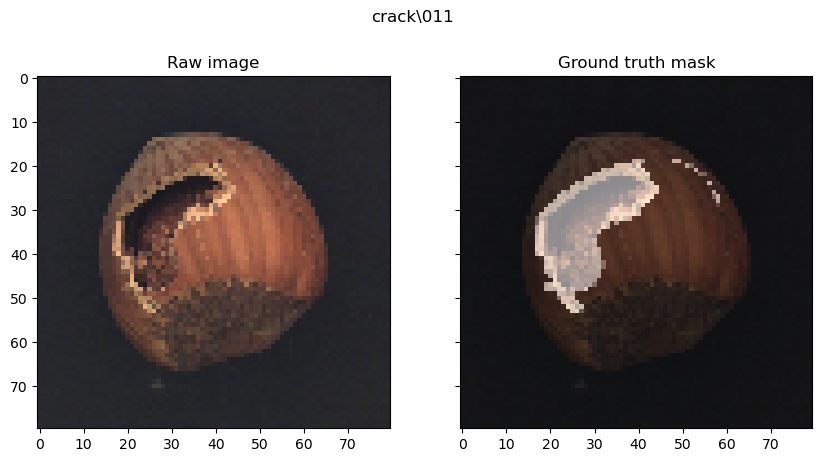

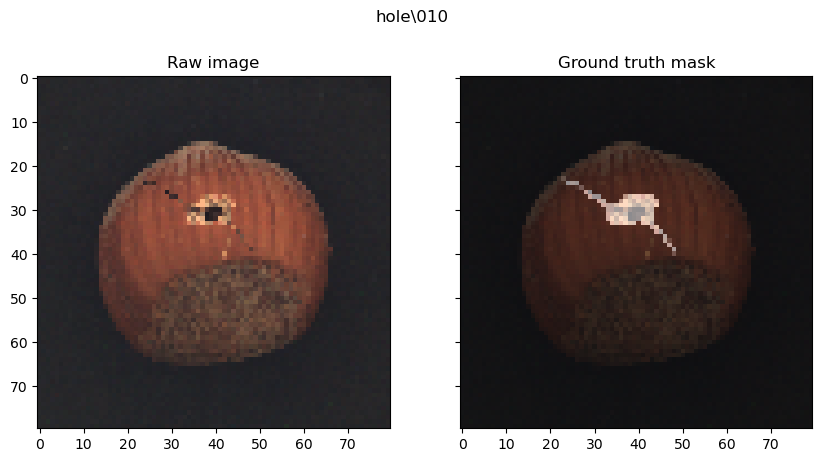

In [7]:
show_img_and_mask(img1, mask1, ex_name1)
show_img_and_mask(img2, mask2, ex_name2)

Some hyperparameters

simple_vit_ft_good.pt

```python
PATCH_SIZE = 10
HIDDEN_DIM = 128

# Load pretrained model
model = vit.SimpleViT(
    image_size = 300,
    patch_size = PATCH_SIZE,
    num_classes = 1,
    dim = HIDDEN_DIM,
    depth = 1,
    heads = 12,
    mlp_dim = 256
).to("cpu")
```

## Initialize model from scratch

In [51]:
# Pretrained model hyper-parameters
CHECKPOINT_PATH = ".." + cons.DIR_SEP + os.path.join("results")
PATCH_SIZE = 10
HIDDEN_DIM = 128

# Load pretrained model
model = vit.SimpleViT(
    image_size = 300,
    patch_size = PATCH_SIZE,
    num_classes = 1,
    dim = HIDDEN_DIM,
    depth = 1,
    heads = 12,
    mlp_dim = 256
).to("cpu")

# model.linear_head[-1] = nn.Sequential(
#     nn.Linear(HIDDEN_DIM, HIDDEN_DIM),
#     nn.ReLU(),
#     nn.Linear(HIDDEN_DIM, 1)
# )

def count_trainable_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def count_frozen_parameters(model):
    return sum(p.numel() for p in model.parameters() if not p.requires_grad)

print(f"Trainable params: {count_trainable_parameters(model)}")
print(f"Frozen params: {count_frozen_parameters(model)}")

model

Trainable params: 498561
Frozen params: 0


SimpleViT(
  (to_patch_embedding): Sequential(
    (0): Rearrange('b c (h p1) (w p2) -> b h w (p1 p2 c)', p1=10, p2=10)
    (1): Linear(in_features=300, out_features=128, bias=True)
  )
  (transformer): Transformer(
    (layers): ModuleList(
      (0): ModuleList(
        (0): Attention(
          (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (attend): Softmax(dim=-1)
          (to_qkv): Linear(in_features=128, out_features=2304, bias=False)
          (to_out): Linear(in_features=768, out_features=128, bias=False)
        )
        (1): FeedForward(
          (net): Sequential(
            (0): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
            (1): Linear(in_features=128, out_features=256, bias=True)
            (2): GELU(approximate='none')
            (3): Linear(in_features=256, out_features=128, bias=True)
          )
        )
      )
    )
  )
  (to_latent): Identity()
  (linear_head): Sequential(
    (0): LayerNorm((128,), eps=1e-05, ele

## Train from scratch

In [52]:
def evaluate(model, data_loader, **kwargs):
    loss_fn = kwargs.get("loss_fn", nn.BCEWithLogitsLoss())
    device = kwargs.get("device", torch.device("cpu"))
    
    model.eval() # set model to evaluation mode
    pbar = tqdm(enumerate(data_loader), total=len(data_loader))
    avg_loss, avg_acc = 0., 0.
    for i, batch in pbar:

        inputs, targets = batch["inputs"], batch["labels"]
        inputs, targets = inputs.to(device), targets.to(device)
        
        model.zero_grad() # initialize gradients to zero
        with torch.no_grad(): # no need to compute gradients
            logits = model(inputs)
            preds = torch.sigmoid(logits)
            pred_cats = preds > 0.5
            acc = (pred_cats == targets).float().mean()
           
        loss = loss_fn(logits, targets.float())
        avg_loss += loss.item()
        avg_acc += acc.item()
        pbar.set_description(f"loss = {loss:.3f} | acc = {acc:.3f}")
    avg_loss /= len(data_loader)
    avg_acc /= len(data_loader)
    return avg_loss, avg_acc

def fit(model, train_loader, val_loader, optimizer, **kwargs):
    loss_fn = kwargs.get("loss_fn", nn.BCEWithLogitsLoss())
    device = kwargs.get("device", torch.device("cpu"))
    num_epochs = kwargs.get("num_epochs", 100)
    scheduler = kwargs.get("scheduler", None)

    train_loss_hist, val_loss_hist = [], []
    train_acc_hist, val_acc_hist = [], []

    for epoch in range(num_epochs):
        # Checkpoint if validation loss improves  
        if epoch > 2 and val_loss_hist[-2] > val_loss_hist[-1]:
            torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': val_loss_hist[-1],
                    }, os.path.join(CHECKPOINT_PATH, "simple_vit_ft.pt"))

        print(f"\nEpoch {epoch + 1}/{num_epochs}")
        model.train() # set model to training mode
        train_loss, train_acc = 0., 0.
        pbar = tqdm(enumerate(train_loader), total=len(train_loader))

        try:
            for i, batch in pbar:
                
                inputs, targets = batch["inputs"], batch["labels"]
                inputs, targets = inputs.to(device), targets.to(device)
        
                # print(f"Batch - Input: {inputs.shape, type(inputs), inputs.dtype} Target: {targets.shape, type(targets), targets.dtype}")

                model.zero_grad() # initialize gradients to zero
                logits = model(inputs) # forward pass

                # print(f"Logits - {logits.shape}, {type(logits)}, {logits.dtype}")

                loss = loss_fn(logits, targets.float()) # loss computation
                loss.backward() # computing gradients (backward pass)
                
                optimizer.step() # updating the parameters of the model

                if scheduler is not None:
                    scheduler.step()

                # accuracy computation
                with torch.no_grad():
                    preds = torch.sigmoid(logits)
                    pred_cats = preds > 0.5
                    acc = (pred_cats == targets).float().mean()
        
                # pop computational graph
                train_loss += loss.item()
                train_acc += acc.item() 
                pbar.set_description(f"loss = {loss:.3f} | acc = {acc:.3f}")
            

            train_loss /= len(train_loader)
            train_acc /= len(train_loader)
            print(f"Train loss: {train_loss:.3f} | train acc = {train_acc:.3f}")
            train_loss_hist.append(train_loss)
            train_acc_hist.append(train_acc) 
            
            val_loss, val_acc = evaluate(model, val_loader, loss_fn=loss_fn, device=device)
            print(f"Validation loss: {val_loss:.3f} | val acc = {val_acc:.3f}")
            val_loss_hist.append(val_loss)
            val_acc_hist.append(val_acc)

        except KeyboardInterrupt:
            return train_loss_hist, val_loss_hist, train_acc_hist, val_acc_hist            

    return train_loss_hist, val_loss_hist, train_acc_hist, val_acc_hist

In [53]:
# Define training parameters
LEARNING_RATE = 1e-4
NUM_EPOCHS = 40
print("BATCH SIZE: ", BATCH_SIZE)
print("CHECKPOINT PATH: ", CHECKPOINT_PATH)
print(f"Total parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad) :.2e}")

# Define loss and optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Schedule learning rate decay
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

WEIGHT = torch.tensor(class_ratio) # Account for class imbalance in training data
print(f"Ratio negative/positive: {class_ratio}")
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=WEIGHT)
# criterion = torch.nn.BCEWithLogitsLoss()

# Attempt training on GPU
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
# elif torch.backends.mps.is_available():
#     DEVICE = torch.device('mps')
else:
    DEVICE = torch.device('cpu')
print('DEVICE:', DEVICE)

# Send to device
model = model.to(DEVICE)
print(torch.cuda.memory_summary())

BATCH SIZE:  8
CHECKPOINT PATH:  ..\results
Total parameters: 4.99e+05
Ratio negative/positive: 5.622641509433962
DEVICE: cuda
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 1         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |   24019 KB |    3266 MB |   50376 GB |   50376 GB |
|       from large pool |    1152 KB |    3218 MB |   50176 GB |   50176 GB |
|       from small pool |   22867 KB |      52 MB |     199 GB |     199 GB |
|---------------------------------------------------------------------------|
| Active memory

In [54]:
# Training
train_loss, val_loss, train_acc, val_acc = fit(model, train_dataloader, val_dataloader, optimizer,
                                               loss_fn=criterion, num_epochs=NUM_EPOCHS, device=DEVICE)


Epoch 1/40


loss = 1.155 | acc = 0.857: 100%|██████████| 44/44 [00:15<00:00,  2.76it/s]


Train loss: 1.209 | train acc = 0.497


loss = 0.544 | acc = 1.000: 100%|██████████| 7/7 [00:01<00:00,  3.57it/s]


Validation loss: 0.852 | val acc = 0.929

Epoch 2/40


loss = 1.234 | acc = 0.143: 100%|██████████| 44/44 [00:16<00:00,  2.74it/s]


Train loss: 1.229 | train acc = 0.597


loss = 1.112 | acc = 0.000: 100%|██████████| 7/7 [00:01<00:00,  3.83it/s]


Validation loss: 1.190 | val acc = 0.071

Epoch 3/40


loss = 0.671 | acc = 1.000: 100%|██████████| 44/44 [00:15<00:00,  2.92it/s]


Train loss: 1.215 | train acc = 0.517


loss = 2.347 | acc = 0.500: 100%|██████████| 7/7 [00:01<00:00,  3.94it/s]


Validation loss: 1.083 | val acc = 0.875

Epoch 4/40


loss = 0.545 | acc = 1.000: 100%|██████████| 44/44 [00:14<00:00,  2.95it/s]


Train loss: 1.183 | train acc = 0.389


loss = 2.826 | acc = 0.500: 100%|██████████| 7/7 [00:01<00:00,  4.01it/s]


Validation loss: 1.084 | val acc = 0.875

Epoch 5/40


loss = 0.637 | acc = 1.000: 100%|██████████| 44/44 [00:15<00:00,  2.90it/s]


Train loss: 1.223 | train acc = 0.480


loss = 0.605 | acc = 1.000: 100%|██████████| 7/7 [00:01<00:00,  3.91it/s]


Validation loss: 0.874 | val acc = 0.929

Epoch 6/40


loss = 1.613 | acc = 0.571: 100%|██████████| 44/44 [00:15<00:00,  2.77it/s]


Train loss: 1.193 | train acc = 0.834


loss = 0.680 | acc = 1.000: 100%|██████████| 7/7 [00:01<00:00,  3.83it/s]


Validation loss: 0.916 | val acc = 0.589

Epoch 7/40


loss = 1.148 | acc = 0.857: 100%|██████████| 44/44 [00:15<00:00,  2.87it/s]


Train loss: 1.203 | train acc = 0.403


loss = 2.320 | acc = 0.500: 100%|██████████| 7/7 [00:01<00:00,  3.65it/s]


Validation loss: 1.081 | val acc = 0.839

Epoch 8/40


loss = 1.145 | acc = 0.857: 100%|██████████| 44/44 [00:19<00:00,  2.24it/s]


Train loss: 1.197 | train acc = 0.483


loss = 0.567 | acc = 1.000: 100%|██████████| 7/7 [00:02<00:00,  2.90it/s]


Validation loss: 0.860 | val acc = 0.929

Epoch 9/40


loss = 1.165 | acc = 0.143: 100%|██████████| 44/44 [00:19<00:00,  2.22it/s]


Train loss: 1.171 | train acc = 0.753


loss = 0.818 | acc = 0.000: 100%|██████████| 7/7 [00:02<00:00,  2.80it/s]


Validation loss: 0.979 | val acc = 0.071

Epoch 10/40


loss = 1.144 | acc = 0.714: 100%|██████████| 44/44 [00:18<00:00,  2.34it/s]


Train loss: 1.182 | train acc = 0.488


loss = 0.683 | acc = 0.500: 100%|██████████| 7/7 [00:01<00:00,  4.00it/s]


Validation loss: 0.901 | val acc = 0.804

Epoch 11/40


loss = 1.149 | acc = 0.857: 100%|██████████| 44/44 [00:14<00:00,  2.95it/s]


Train loss: 1.193 | train acc = 0.525


loss = 2.459 | acc = 0.500: 100%|██████████| 7/7 [00:01<00:00,  3.98it/s]


Validation loss: 1.065 | val acc = 0.875

Epoch 12/40


loss = 1.159 | acc = 0.143: 100%|██████████| 44/44 [00:14<00:00,  2.97it/s]


Train loss: 1.187 | train acc = 0.665


loss = 1.858 | acc = 0.500: 100%|██████████| 7/7 [00:01<00:00,  4.05it/s]


Validation loss: 1.133 | val acc = 0.125

Epoch 13/40


loss = 1.595 | acc = 0.429: 100%|██████████| 44/44 [00:14<00:00,  3.00it/s]


Train loss: 1.192 | train acc = 0.498


loss = 0.710 | acc = 0.000: 100%|██████████| 7/7 [00:01<00:00,  4.01it/s]


Validation loss: 0.920 | val acc = 0.268

Epoch 14/40


loss = 1.116 | acc = 0.571: 100%|██████████| 44/44 [00:14<00:00,  2.96it/s]


Train loss: 1.183 | train acc = 0.541


loss = 2.149 | acc = 0.500: 100%|██████████| 7/7 [00:01<00:00,  3.95it/s]


Validation loss: 1.075 | val acc = 0.304

Epoch 15/40


loss = 1.106 | acc = 0.857: 100%|██████████| 44/44 [00:14<00:00,  2.98it/s]


Train loss: 1.168 | train acc = 0.383


loss = 0.636 | acc = 1.000: 100%|██████████| 7/7 [00:01<00:00,  4.00it/s]


Validation loss: 0.867 | val acc = 0.946

Epoch 16/40


loss = 1.144 | acc = 0.571: 100%|██████████| 44/44 [00:14<00:00,  2.95it/s]


Train loss: 1.132 | train acc = 0.655


loss = 0.673 | acc = 1.000: 100%|██████████| 7/7 [00:01<00:00,  3.97it/s]


Validation loss: 0.892 | val acc = 0.482

Epoch 17/40


loss = 0.557 | acc = 0.857: 100%|██████████| 44/44 [00:14<00:00,  2.95it/s]


Train loss: 1.028 | train acc = 0.602


loss = 0.688 | acc = 0.500: 100%|██████████| 7/7 [00:01<00:00,  3.96it/s]


Validation loss: 0.817 | val acc = 0.643

Epoch 18/40


loss = 0.968 | acc = 0.857: 100%|██████████| 44/44 [00:14<00:00,  2.97it/s]


Train loss: 0.921 | train acc = 0.784


loss = 0.775 | acc = 0.500: 100%|██████████| 7/7 [00:01<00:00,  3.97it/s]


Validation loss: 0.793 | val acc = 0.696

Epoch 19/40


loss = 0.597 | acc = 1.000: 100%|██████████| 44/44 [00:15<00:00,  2.93it/s]


Train loss: 0.771 | train acc = 0.818


loss = 0.216 | acc = 1.000: 100%|██████████| 7/7 [00:01<00:00,  4.00it/s]


Validation loss: 0.975 | val acc = 0.661

Epoch 20/40


loss = 0.150 | acc = 1.000: 100%|██████████| 44/44 [00:14<00:00,  2.98it/s]


Train loss: 0.800 | train acc = 0.790


loss = 1.978 | acc = 1.000: 100%|██████████| 7/7 [00:01<00:00,  4.05it/s]


Validation loss: 0.792 | val acc = 0.911

Epoch 21/40


loss = 0.174 | acc = 1.000: 100%|██████████| 44/44 [00:15<00:00,  2.93it/s]


Train loss: 0.776 | train acc = 0.815


loss = 0.119 | acc = 1.000: 100%|██████████| 7/7 [00:01<00:00,  3.99it/s]


Validation loss: 0.587 | val acc = 0.929

Epoch 22/40


loss = 0.170 | acc = 1.000: 100%|██████████| 44/44 [00:15<00:00,  2.93it/s]


Train loss: 0.705 | train acc = 0.855


loss = 0.411 | acc = 1.000: 100%|██████████| 7/7 [00:01<00:00,  3.94it/s]


Validation loss: 0.681 | val acc = 0.839

Epoch 23/40


loss = 0.617 | acc = 0.714: 100%|██████████| 44/44 [00:14<00:00,  2.94it/s]


Train loss: 0.669 | train acc = 0.863


loss = 0.294 | acc = 1.000: 100%|██████████| 7/7 [00:01<00:00,  4.03it/s]


Validation loss: 0.627 | val acc = 0.857

Epoch 24/40


loss = 0.220 | acc = 0.857: 100%|██████████| 44/44 [00:14<00:00,  2.94it/s]


Train loss: 0.661 | train acc = 0.852


loss = 0.054 | acc = 1.000: 100%|██████████| 7/7 [00:01<00:00,  3.93it/s]


Validation loss: 0.552 | val acc = 0.875

Epoch 25/40


loss = 0.184 | acc = 1.000: 100%|██████████| 44/44 [00:14<00:00,  2.94it/s]


Train loss: 0.593 | train acc = 0.895


loss = 1.966 | acc = 0.000: 100%|██████████| 7/7 [00:01<00:00,  3.99it/s]


Validation loss: 0.846 | val acc = 0.714

Epoch 26/40


loss = 0.284 | acc = 0.857: 100%|██████████| 44/44 [00:15<00:00,  2.93it/s]


Train loss: 0.526 | train acc = 0.883


loss = 0.149 | acc = 1.000: 100%|██████████| 7/7 [00:01<00:00,  3.94it/s]


Validation loss: 0.540 | val acc = 0.875

Epoch 27/40


loss = 0.721 | acc = 0.714: 100%|██████████| 44/44 [00:15<00:00,  2.85it/s]


Train loss: 0.469 | train acc = 0.911


loss = 0.063 | acc = 1.000: 100%|██████████| 7/7 [00:01<00:00,  3.97it/s]


Validation loss: 0.523 | val acc = 0.839

Epoch 28/40


loss = 0.043 | acc = 1.000: 100%|██████████| 44/44 [00:14<00:00,  2.97it/s]


Train loss: 0.451 | train acc = 0.889


loss = 0.050 | acc = 1.000: 100%|██████████| 7/7 [00:01<00:00,  3.98it/s]


Validation loss: 0.487 | val acc = 0.964

Epoch 29/40


loss = 0.167 | acc = 0.857: 100%|██████████| 44/44 [00:14<00:00,  2.96it/s]


Train loss: 0.560 | train acc = 0.889


loss = 0.865 | acc = 1.000: 100%|██████████| 7/7 [00:01<00:00,  3.98it/s]


Validation loss: 0.553 | val acc = 0.911

Epoch 30/40


loss = 0.128 | acc = 1.000: 100%|██████████| 44/44 [00:14<00:00,  2.95it/s]


Train loss: 0.409 | train acc = 0.955


loss = 0.082 | acc = 1.000: 100%|██████████| 7/7 [00:01<00:00,  3.89it/s]


Validation loss: 0.404 | val acc = 0.929

Epoch 31/40


loss = 1.178 | acc = 0.857: 100%|██████████| 44/44 [00:14<00:00,  2.95it/s]


Train loss: 0.390 | train acc = 0.926


loss = 0.069 | acc = 1.000: 100%|██████████| 7/7 [00:01<00:00,  3.86it/s]


Validation loss: 0.389 | val acc = 0.946

Epoch 32/40


loss = 1.035 | acc = 0.571: 100%|██████████| 44/44 [00:14<00:00,  2.94it/s]


Train loss: 0.333 | train acc = 0.939


loss = 0.402 | acc = 0.500: 100%|██████████| 7/7 [00:01<00:00,  3.96it/s]


Validation loss: 0.604 | val acc = 0.804

Epoch 33/40


loss = 0.183 | acc = 0.857: 100%|██████████| 44/44 [00:15<00:00,  2.92it/s]


Train loss: 0.331 | train acc = 0.960


loss = 0.429 | acc = 0.500: 100%|██████████| 7/7 [00:01<00:00,  3.92it/s]


Validation loss: 0.462 | val acc = 0.857

Epoch 34/40


loss = 0.143 | acc = 1.000: 100%|██████████| 44/44 [00:15<00:00,  2.92it/s]


Train loss: 0.492 | train acc = 0.906


loss = 0.478 | acc = 0.500: 100%|██████████| 7/7 [00:01<00:00,  3.94it/s]


Validation loss: 0.574 | val acc = 0.821

Epoch 35/40


loss = 2.659 | acc = 0.857: 100%|██████████| 44/44 [00:14<00:00,  2.95it/s]


Train loss: 0.385 | train acc = 0.946


loss = 0.044 | acc = 1.000: 100%|██████████| 7/7 [00:01<00:00,  4.03it/s]


Validation loss: 0.390 | val acc = 0.964

Epoch 36/40


loss = 0.061 | acc = 1.000: 100%|██████████| 44/44 [00:14<00:00,  2.94it/s]


Train loss: 0.330 | train acc = 0.946


loss = 0.913 | acc = 0.500: 100%|██████████| 7/7 [00:01<00:00,  3.94it/s]


Validation loss: 0.498 | val acc = 0.875

Epoch 37/40


loss = 0.104 | acc = 1.000: 100%|██████████| 44/44 [00:15<00:00,  2.89it/s]


Train loss: 0.288 | train acc = 0.960


loss = 0.092 | acc = 1.000: 100%|██████████| 7/7 [00:01<00:00,  3.95it/s]


Validation loss: 0.359 | val acc = 0.964

Epoch 38/40


loss = 0.067 | acc = 1.000: 100%|██████████| 44/44 [00:15<00:00,  2.92it/s]


Train loss: 0.284 | train acc = 0.960


loss = 0.119 | acc = 1.000: 100%|██████████| 7/7 [00:01<00:00,  3.93it/s]


Validation loss: 0.392 | val acc = 0.964

Epoch 39/40


loss = 0.399 | acc = 0.714: 100%|██████████| 44/44 [00:15<00:00,  2.93it/s]


Train loss: 0.319 | train acc = 0.945


loss = 0.057 | acc = 1.000: 100%|██████████| 7/7 [00:01<00:00,  3.85it/s]


Validation loss: 0.575 | val acc = 0.804

Epoch 40/40


loss = 0.090 | acc = 1.000: 100%|██████████| 44/44 [00:15<00:00,  2.86it/s]


Train loss: 0.281 | train acc = 0.943


loss = 0.029 | acc = 1.000: 100%|██████████| 7/7 [00:01<00:00,  3.90it/s]

Validation loss: 0.424 | val acc = 0.929


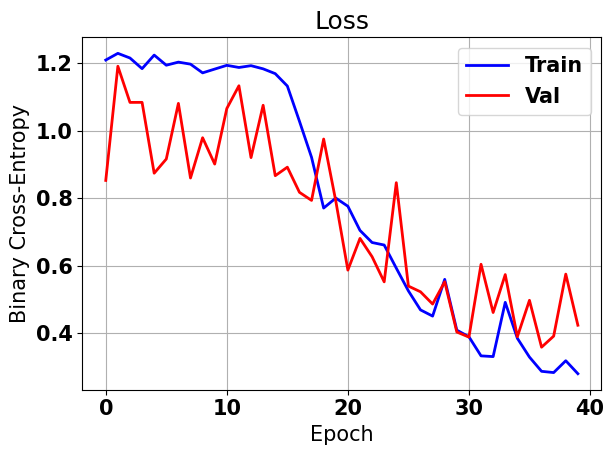

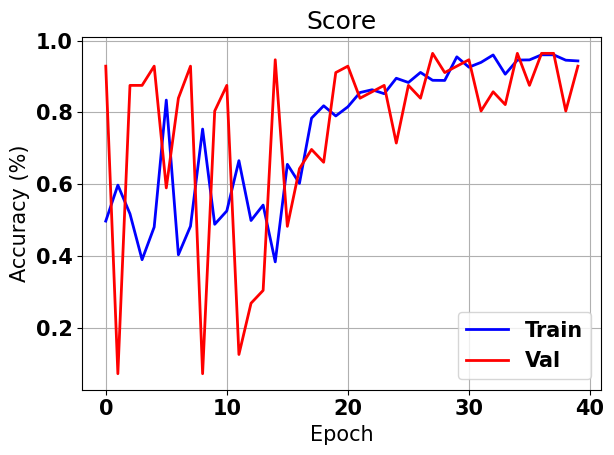

In [55]:
# Plot loss and accuracy
with plt.rc_context(rc={'font.size': 15, 'font.weight': 'bold'}):
    plt.figure()
    plt.title("Loss")
    plt.plot(train_loss, lw=2.0, c="b", label="Train")
    plt.plot(val_loss, lw=2.0, c="r", label="Val")
    plt.xlabel("Epoch")
    plt.ylabel("Binary Cross-Entropy")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()
    ####
    plt.figure()
    plt.title("Score")
    plt.plot(train_acc, lw=2.0, c="b", label="Train")
    plt.plot(val_acc, lw=2.0, c="r", label="Val")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

In [56]:
# Visualize attention layers
def predict_with_attention(model, data_loader, **kwargs):
    device = kwargs.get("device", torch.device("cpu"))

    images, labels, results, attn_weights = [], [], [], []

    model.eval() # set model to evaluation mode
    pbar = tqdm(enumerate(data_loader), total=len(data_loader))
    for i, batch in pbar:

        data, targets = batch["inputs"], batch["labels"]
        data, targets = data.to(device), targets.to(device)
        
        model.zero_grad() # initialize gradients to zero
        with torch.no_grad(): # no need to compute gradients
            logits, attns = model(data) # attns: (batch x layers x heads x patch x patch)
            preds = torch.sigmoid(logits)
            pred_cats = preds > 0.5

        attns = attns.mean(dim=2) # average over heads
        attns_prod = attns[:, 0] # recursively multiply attentions
        for i in range(1, attns.shape[1]):
            attns_prod = torch.matmul(attns_prod, attns[:, i])

        images.append(data)
        labels.append(targets)
        results.append(pred_cats)
        attn_weights.append(attns_prod)

    images = torch.concat(tuple([image for image in images]), dim=0)
    labels = torch.concat(tuple([label for label in labels]))
    results = torch.concat(tuple([result for result in results]))
    attn_weights = torch.concat(tuple([attn for attn in attn_weights]))

    return images, labels, results, attn_weights

In [57]:
# Pretrained model hyper-parameters
CHECKPOINT_PATH = ".." + cons.DIR_SEP + os.path.join("results")
PATCH_SIZE = 10
HIDDEN_DIM = 128

# Load pretrained model
model = vit.SimpleViT(
    image_size = 300,
    patch_size = PATCH_SIZE,
    num_classes = 1,
    dim = HIDDEN_DIM,
    depth = 1,
    heads = 12,
    mlp_dim = 256
).to("cpu")

loaded = torch.load(os.path.join(CHECKPOINT_PATH, "simple_vit_ft.pt"))
print(f"Loaded model, epoch:{loaded['epoch']}, loss:{loaded['loss']}")
model.load_state_dict(loaded["model_state_dict"])


model = Recorder(model) # set up model to return attention weights in forward pass
images, labels, pred_cats, attns = predict_with_attention(model, test_dataloader)
model = model.eject() # remove hooks from forward pass


print(images.shape, labels.shape, pred_cats.shape, attns.shape)

Loaded model, epoch:37, loss:0.35893463982003077


100%|██████████| 13/13 [00:16<00:00,  1.28s/it]


torch.Size([100, 3, 300, 300]) torch.Size([100, 1]) torch.Size([100, 1]) torch.Size([100, 900, 900])


In [58]:
%matplotlib inline
# Refs: https://www.kaggle.com/code/piantic/vision-transformer-vit-visualize-attention-map/notebook

def plot_attentions(images, labels, pred_Cats, attns, start_idx=0, n_rows=5):
    fig, ax = plt.subplots(1, n_rows, figsize=(8, 3))
    with plt.rc_context(rc={'font.size': 9}):
        for i in range(start_idx, start_idx + 5):
            ca = ax[i % 5]
            # Plot correct predictions for anomalous objects
            img = images[i]
            img_label = labels[i]
            pred_label = pred_cats[i]
            resize = transforms.Resize((300, 300))
            
            attns_raw = attns[i]
            attns_vals = attns_raw[-1]
            mask = attns_vals.reshape(30, 30)
            mask = resize(mask.unsqueeze(0)).squeeze()
            mask = mask.detach().numpy()
            mask = (mask - mask.min())/(mask.max() - mask.min())

            img_perm = torch.permute(img, (1, 2, 0)).cpu().numpy()
            ca.imshow(img_perm, aspect="auto")
            ca.imshow(mask, aspect="auto", alpha=mask, cmap="viridis")
        
            if pred_label.int().item() == img_label.item():
                ca.set_title(f"{pred_label.int().item()} / {img_label.item()}", color="green")
            else:
                ca.set_title(f"{pred_label.int().item()} / {img_label.item()}", color="red")

            ca.set_axis_off()
        
        fig.tight_layout()

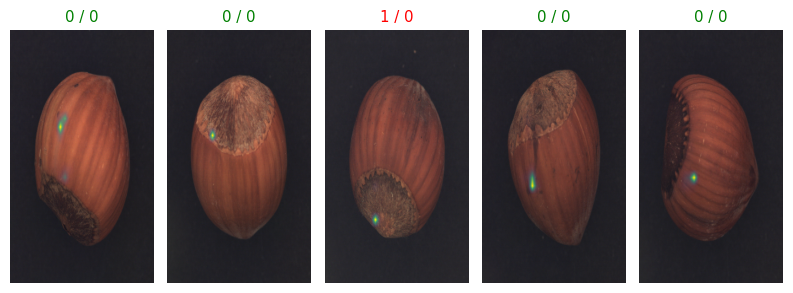

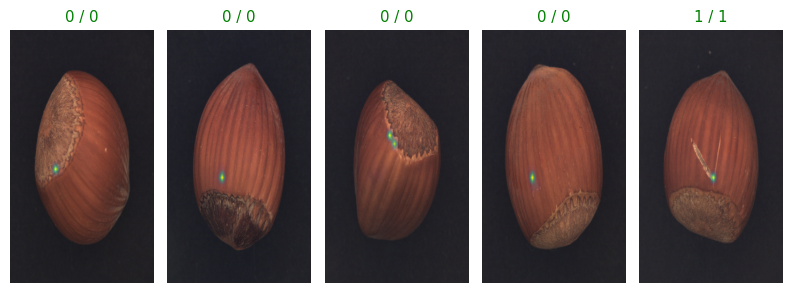

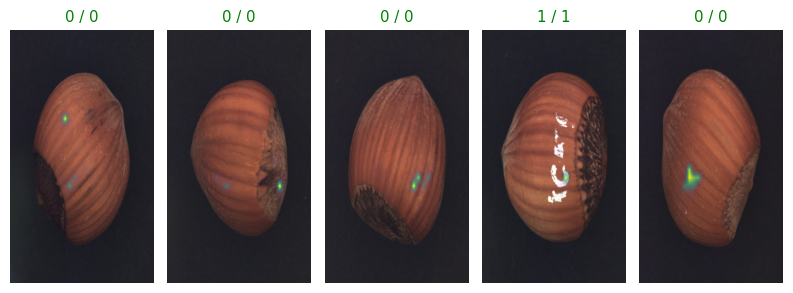

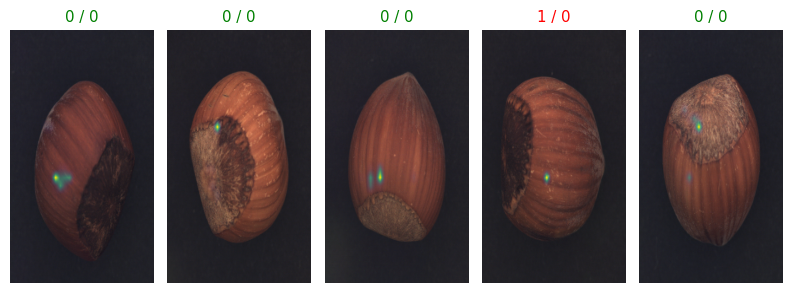

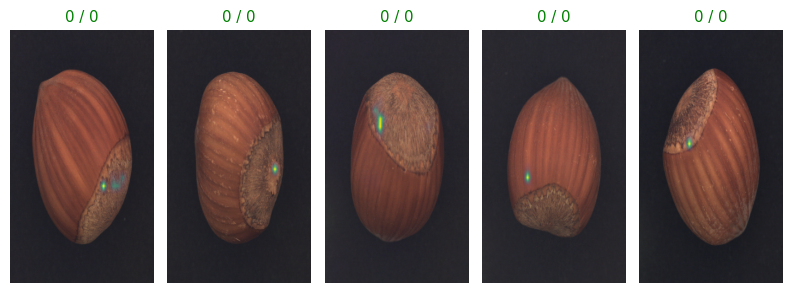

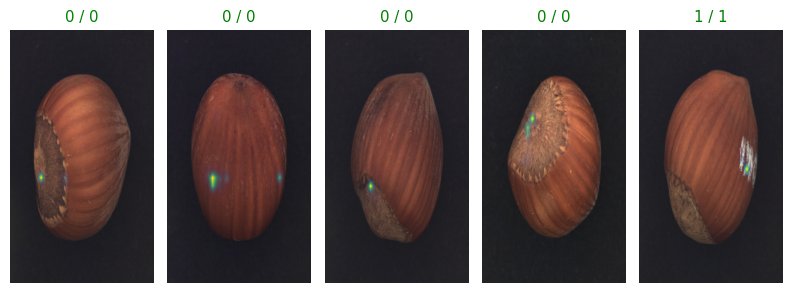

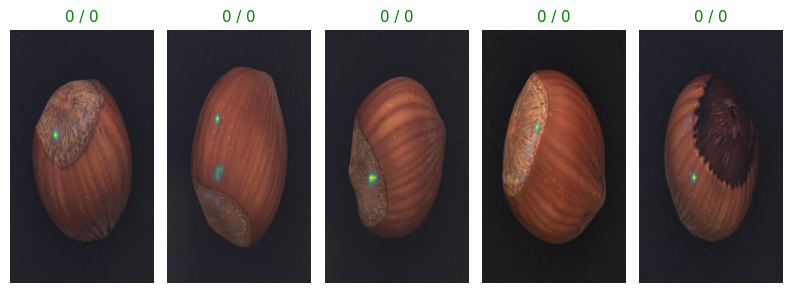

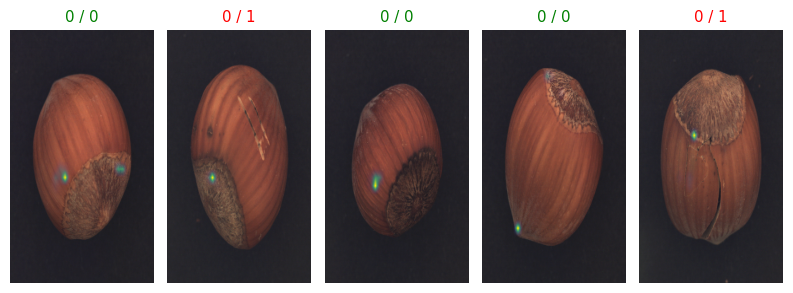

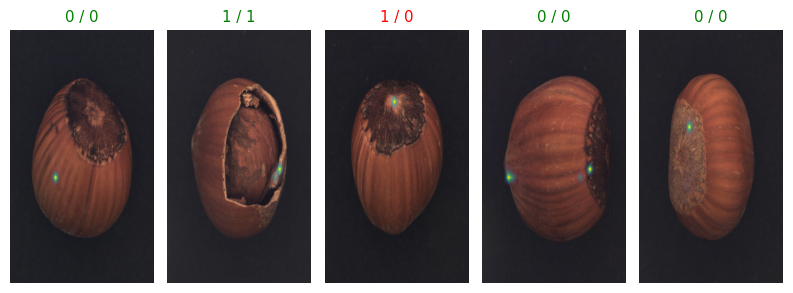

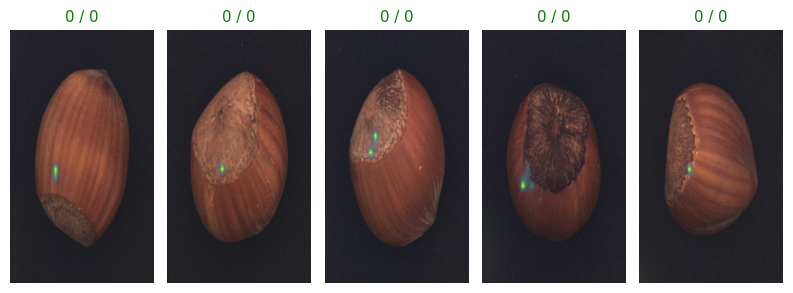

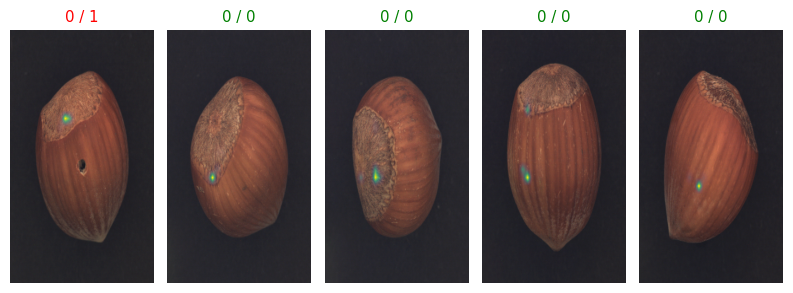

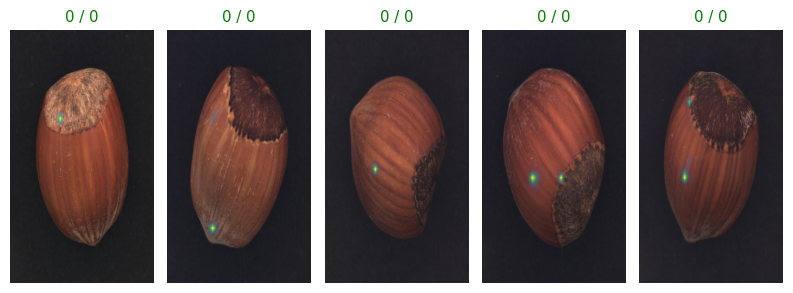

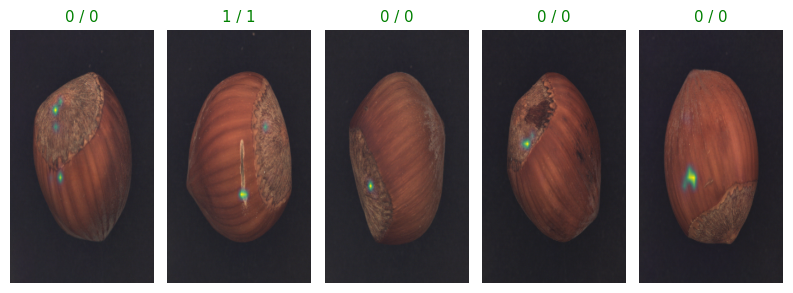

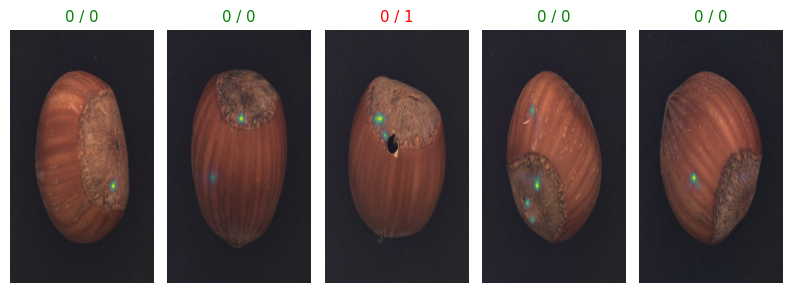

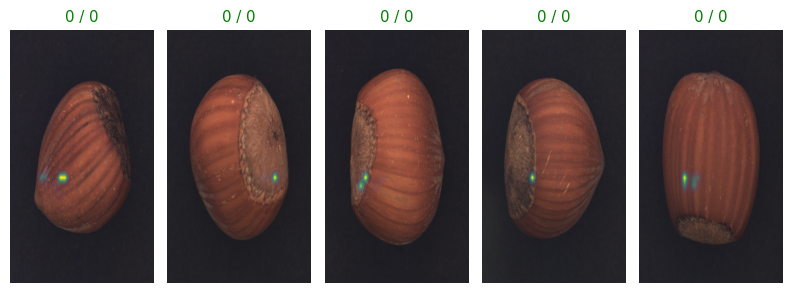

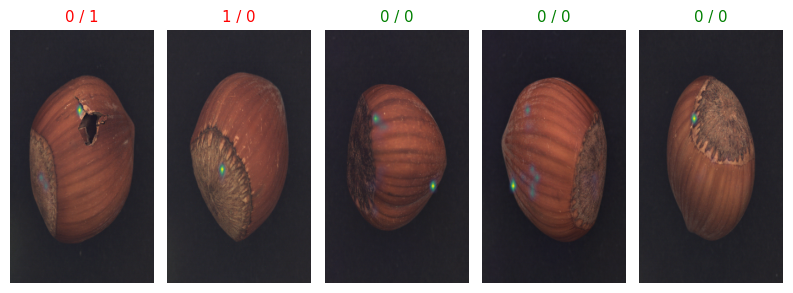

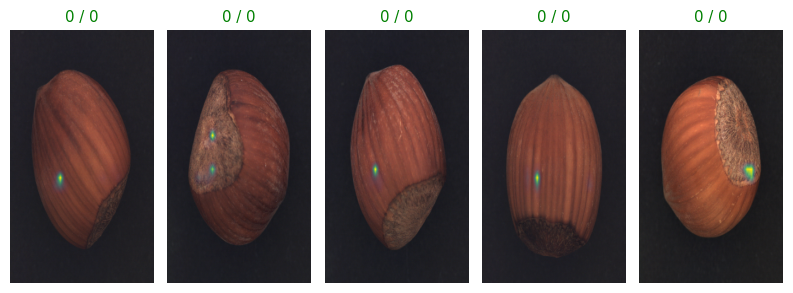

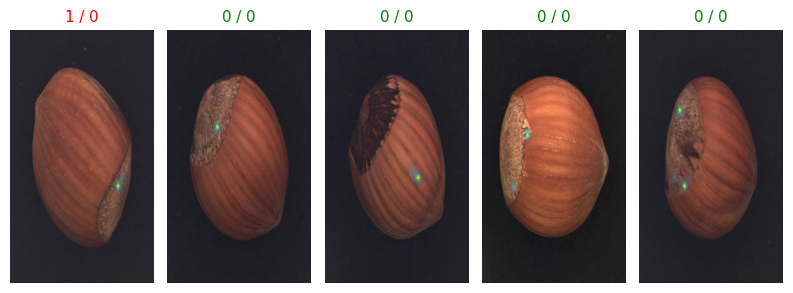

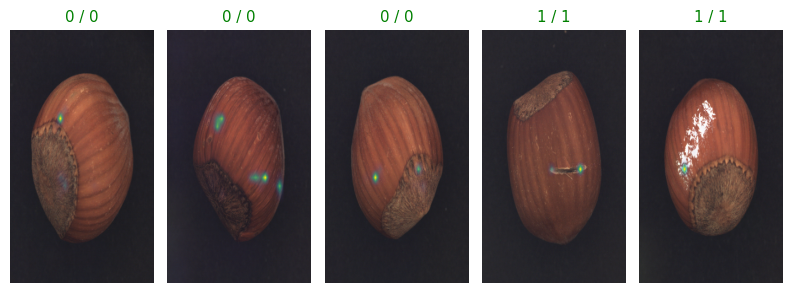

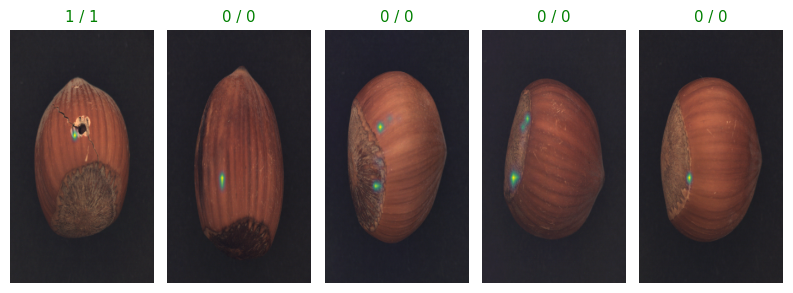

In [59]:
for i in range(0, images.shape[0]-1, 5):
    plot_attentions(images, labels, pred_cats, attns, start_idx=i)

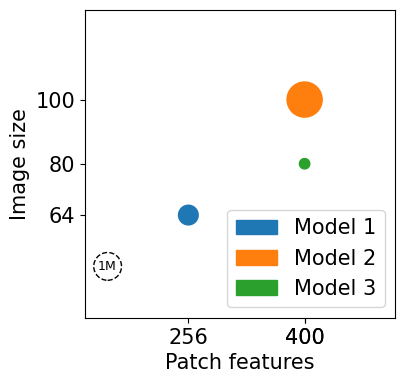

In [36]:
from matplotlib.patches import Patch, Circle
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import numpy as np

size_scaling = 400
total_params = size_scaling * np.array([1.721, 0.2885, 1.407]) # ref: 1M
image_size = [64, 100, 80]
patch_feat = [256, 400, 400]

colors = ["C0", "C1", "C2"]

with plt.rc_context(rc={'font.size': 15}): 
    plt.figure(figsize=(4, 4))    
    plt.scatter(patch_feat, image_size, s=total_params, c=colors)

    plt.scatter([156], [48], c="none", s=size_scaling, ls="--", ec="k")
    plt.text(144, 47, "1M", fontsize=9)

    plt.xlim([128, 512])
    plt.ylim([32, 128])

    plt.xticks(patch_feat)
    plt.yticks(image_size)

    plt.xlabel("Patch features")
    plt.ylabel("Image size")

    legend_elements = [
        Patch(facecolor="C0", edgecolor="C0", label="Model 1"),
        Patch(facecolor="C1", edgecolor="C1", label="Model 2"),
        Patch(facecolor="C2", edgecolor="C2", label="Model 3"),
    ]

    plt.legend(handles=legend_elements, loc="lower right")
# plt.tight_layout()